In [5]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [6]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

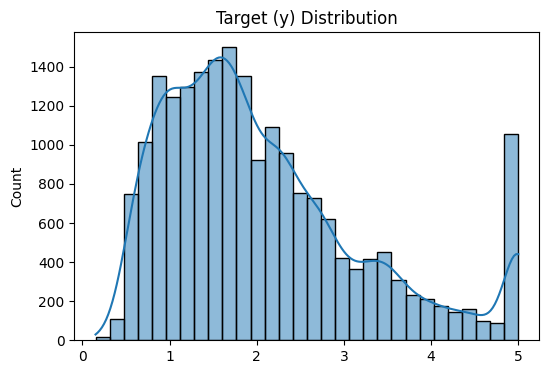

In [8]:
from sklearn.datasets import fetch_california_housing
import numpy as np

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

X = X.values.astype(float)
y = np.array(y).reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True, bins=30)
plt.title("Target (y) Distribution")
plt.show()

# Gelman-Rubin R

In [9]:
n_chains = 4
chains_mtmh = []
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
for i in range(n_chains):
    bart = MultiBART(ndpost=1000, nskip=100, n_trees=100, proposal_probs=proposal_probs, multi_tries=10, random_state=i)
    bart.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'][0] for trace in bart.sampler.trace]
    chains_mtmh.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_mtmh)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]

Gelman-Rubin R̂: <xarray.Dataset> Size: 8B
Dimensions:     ()
Data variables:
    eps_sigma2  float64 8B 1.769


In [10]:
n_chains = 4
chains_default = []
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
for i in range(n_chains):
    bart_default = DefaultBART(ndpost=1000, nskip=100, n_trees=100, proposal_probs=proposal_probs, random_state=i)
    bart_default.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'][0] for trace in bart_default.sampler.trace]
    chains_default.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_default)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 1100/1100 [00:28<00:00, 38.18it/s]

Gelman-Rubin R̂: <xarray.Dataset> Size: 8B
Dimensions:     ()
Data variables:
    eps_sigma2  float64 8B 1.699


In [11]:
import numpy as np

def gelman_rubin_rhat(chains):
    """
    Classic Gelman-Rubin R_hat (Brooks & Gelman 1998).
    chains: shape (n_chains, n_samples)
    Returns: R_hat value
    Note: No chain splitting, no rank normalization.
    """
    chains = np.array(chains, dtype=float)
    chains = np.squeeze(chains)
    if chains.ndim != 2:
        raise ValueError("Input must be 2D array (n_chains, n_samples)")
    m, n = chains.shape
    # Step 1: Compute mean and variance for each chain
    chain_means = np.mean(chains, axis=1)
    chain_vars = np.var(chains, axis=1, ddof=1)
    # Step 2: Between-chain variance
    B = n * np.var(chain_means, ddof=1)
    # Step 3: Within-chain variance
    W = np.mean(chain_vars)
    # Step 4: Estimate of marginal posterior variance
    var_hat = ((n - 1) / n) * W + (1 / n) * B
    # Step 5: R_hat
    R_hat = np.sqrt(var_hat / W)
    return R_hat

chains_array = np.array(chains_mtmh)
print("MTMH Classic Gelman-Rubin R̂:", gelman_rubin_rhat(chains_array))
chains_array = np.squeeze(np.array(chains_default))
print("Classic Gelman-Rubin R̂:", gelman_rubin_rhat(chains_array))

MTMH Classic Gelman-Rubin R̂: 1.0268782096883193
Classic Gelman-Rubin R̂: 1.0001009183181186


In [12]:
def gelman_rubin_rhat_l1(chains):
    """
    Alternative R_hat using L1 norm (mean absolute deviation).
    Measures between-chain and within-chain dispersion using L1 norm.
    """
    m, n = chains.shape
    chain_means = np.mean(chains, axis=1)
    chain_mads = np.mean(np.abs(chains - chain_means[:, None]), axis=1)  # within-chain MAD
    W = np.mean(chain_mads)
    B = np.mean(np.abs(chain_means - np.mean(chain_means)))  # between-chain MAD
    # Combine like classic R_hat, but with L1 norm
    var_hat = ((n - 1) / n) * W + (1 / n) * B
    R_hat_l1 = var_hat / W  # No sqrt for L1
    return R_hat_l1

chains_array = np.array(chains_mtmh)
print("MTMH Classic Gelman-Rubin R̂:", gelman_rubin_rhat_l1(chains_array))
chains_array = np.squeeze(np.array(chains_default))
print("Classic Gelman-Rubin R̂:", gelman_rubin_rhat_l1(chains_array))

MTMH Classic Gelman-Rubin R̂: 0.9992185020791262
Classic Gelman-Rubin R̂: 0.9990318326731829


In [13]:
import numpy as np
from scipy.stats import rankdata, norm

def rhat_rank(chains):
    """
    chains: shape (n_chains, n_samples)
    Returns: rank-normalized split R_hat value
    """
    chains = np.array(chains, dtype=float)
    chains = np.squeeze(chains)
    if chains.ndim != 2:
        raise ValueError("Input must be 2D array (n_chains, n_samples)")
    n_chains, n_samples = chains.shape
    if n_samples < 4 or n_chains < 2:
        return np.nan

    # 1. Split chains
    half = n_samples // 2
    split_chains = np.concatenate([chains[:, :half], chains[:, -half:]], axis=0)

    # 2. Rank-normalize and z-transform
    ranks = rankdata(split_chains.ravel(), method="average")
    c = 3 / 8
    ranks = (ranks - c) / (ranks.size - 2 * c + 1)
    z_split = norm.ppf(ranks).reshape(split_chains.shape)

    # 3. Bulk Rhat
    rhat_bulk = gelman_rubin_rhat(z_split)

    # 4. Tail Rhat (folded z)
    folded = np.abs(split_chains - np.median(split_chains))
    ranks_folded = rankdata(folded.ravel(), method="average")
    ranks_folded = (ranks_folded - c) / (ranks_folded.size - 2 * c + 1)
    z_folded = norm.ppf(ranks_folded).reshape(folded.shape)
    rhat_tail = gelman_rubin_rhat(z_folded)

    # 5. Final rank Rhat
    return max(rhat_bulk, rhat_tail)

chains_array = np.array(chains_mtmh)
print("MTMH Rank R̂:", rhat_rank(chains_array))
chains_array = np.array(chains_default)
print("Default Rank R̂:", rhat_rank(chains_array))

MTMH Rank R̂: 1.768578340061396
Default Rank R̂: 1.6985172971220825


In [14]:
def rhat_l1_rank(chains):
    """
    chains: shape (n_chains, n_samples)
    Returns: rank-normalized split R_hat value
    """
    chains = np.array(chains, dtype=float)
    chains = np.squeeze(chains)
    if chains.ndim != 2:
        raise ValueError("Input must be 2D array (n_chains, n_samples)")
    n_chains, n_samples = chains.shape
    if n_samples < 4 or n_chains < 2:
        return np.nan

    # 1. Split chains
    half = n_samples // 2
    split_chains = np.concatenate([chains[:, :half], chains[:, -half:]], axis=0)

    # 2. Rank-normalize and z-transform
    ranks = rankdata(split_chains.ravel(), method="average")
    c = 3 / 8
    ranks = (ranks - c) / (ranks.size - 2 * c + 1)
    z_split = norm.ppf(ranks).reshape(split_chains.shape)

    # 3. Bulk Rhat
    rhat_bulk = gelman_rubin_rhat_l1(z_split)

    # 4. Tail Rhat (folded z)
    folded = np.abs(split_chains - np.median(split_chains))
    ranks_folded = rankdata(folded.ravel(), method="average")
    ranks_folded = (ranks_folded - c) / (ranks_folded.size - 2 * c + 1)
    z_folded = norm.ppf(ranks_folded).reshape(folded.shape)
    rhat_tail = gelman_rubin_rhat_l1(z_folded)

    # 5. Final rank Rhat
    return max(rhat_bulk, rhat_tail)

chains_array = np.array(chains_mtmh)
print("MTMH Rank R̂ (L1):", rhat_l1_rank(chains_array))
chains_array = np.array(chains_default)
print("Default Rank R̂ (L1):", rhat_l1_rank(chains_array))

MTMH Rank R̂ (L1): 1.0012163701811236
Default Rank R̂ (L1): 1.001198420045106
